# Sharpe Style Analysis
Similar to previous decomposition exercise with the added constraint that all the coefficients are positive and add to 1.

Coefficients of performing style analysis on the observed returns of a manager can be interpreted as weights in a portfolio of building blocks which together _mimic_ that series. Can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain returns.

In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import scipy.stats
from scipy.optimize import minimize

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Performing Sharpe Style Analysis
Obtain weights using the quadratic optimizer; ask the optimizer to find weights that minimize the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

In [6]:
def portfolio_tracking_error(weights, ref_r, bb_r):
    '''
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    '''
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

In [7]:
def style_analysis(dependent_variable, explanatory_variables):
    '''
    Returns the optimal weights that minimizes the tracking error between
    a portfolio of the explanatory variables and the dependent variable
    '''
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    # construct the constraints
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error,
                       init_guess,
                       args=(dependent_variable, explanatory_variables,),
                       method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x,
                       index=explanatory_variables.columns)
    return weights

## Conduct style analysis

In [8]:
ind = erk.get_ind_returns()['2000':]

Construct a manager that invests in 30% beer, 50% smoke, and 20% in other things that have an average return of 0% and an annualized vol of 15%

In [9]:
mgr_r = 0.3*ind['Beer'] + 0.5*ind['Smoke'] + 0.2*np.random.normal(scale=0.15/(12**0.5), size=ind.shape[0])

Assume we know absolutely nothing about this manager and all we observe are the returns. How can we tell what's been invested in?

In [12]:
weights = erk.style_analysis(mgr_r, ind)*100

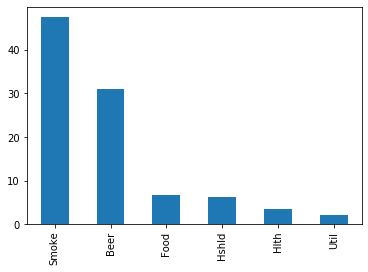

In [15]:
weights.sort_values(ascending=False).head(6).plot.bar()

Quick comparison with results of regression.

In [17]:
coeffs = erk.regress(mgr_r, ind).params*100
coeffs.sort_values().head()

Books   -3.722945
Util    -2.645725
Mines   -2.639322
Servs   -1.376043
Rtail   -1.215791
dtype: float64

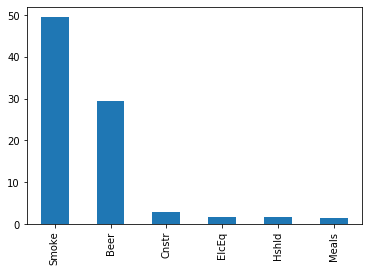

In [19]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

## Warning: Potential Misuse of Style Analysis
Style analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives a very useful and revealing insight if one uses a stock market index (ex: SPY) and other broad indices, ETFs or mutual funds (ex: Value Fund, Growth Fund, International Fund, Bond Fund etc.)

Part of the skill of extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with style analysis is that it will always return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an R square, it will still always give you an answer however unreasonable it might be, and it's not always obvious how much one can rely on the result.